In [1]:
#from google.colab import drive
#drive.mount("/content/gdrive")
import numpy as np
import pandas as pd
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

#Homework 8
In this homework, we will write Gradient Boosting class and apply it to the date from the insuarance company about hospitalization chance. After transformation, data are numpy arrays, not dataframes.

In [13]:
data = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/main/2023_fall/Hospital.csv')
data.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex,DaysInHospital
0,0,3,0,30,M,-1
1,0,0,0,30,M,-1
2,1,0,0,80,F,1
3,0,0,1,20,F,1
4,0,1,0,60,F,-1


In [3]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [5]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['Sex'])], remainder='passthrough')

In [6]:
X_train_transformed = transform.fit_transform(X_train)
X_val_transformed = transform.transform(X_val)
X_test_transformed = transform.transform(X_test)

#Gradient Boosting

$$
a_N(x) = b_0(x)+\eta\sum_{n=1}^N \gamma_n b_n(x) = b_0(x) + \eta \gamma_1 b_1(x) +\ldots + \eta \gamma_N b_N(x)
$$
Prediction is
$$
\hat{y}=\operatorname{sign} a_N(x).
$$

After you built this sum, next model $b_{N+1}(x)$ is trained on
$$
s^{(i)} = -\left.\frac{\partial L(y, z)}{\partial z}\right|_{z=a_N(x^{(i)})}.
$$

After that, $\gamma_{N+1}$ is chosen from the following condition:
$$
L(y, a_N(x)+\gamma_{N+1}b_{N+1}(x)) \to \underset{\gamma_{N+1}}{\min}.
$$

##Q1 (12 pt). Implement boosting for binary classification.

Since gradient boosting is trained by sequentially creating models, it may happen that the model that is optimal in terms of generalization is obtained at an intermediate iteration. Usually, to control this behavior, a validation dataset is also passed to the `fit` method, which allows you to assess the overall model quality during training. In addition, it's not usefull to train a really deep model with 1000 or more trees if the optimal ensemble was achieved, for example, at the 70th iteration and did not improve for some number of iterations. Therefore, we will also use early stopping if there are no improvements over a certain number of iterations.

You will fill-in three things:

1 (4 pt). Function `_fit_new_model`

2 (4 pt). Early stopping in `fit`

3 (4 pt). Function `predict_proba` (Convert $a(x)$ into probability as in logistic regression).

In [18]:
class Boosting:

    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_features': 0.1},
        n_estimators: int=10,
        learning_rate: float=0.1,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=None
    ):

        # Base model class
        self.base_model_class = base_model_class
        # Parameters for the base model
        self.base_model_params = base_model_params
        # Number of the base models
        self.n_estimators = n_estimators
        # Learnin rate (eta)
        self.learning_rate = learning_rate
        # Fraction of the training data for training of the individual model
        self.subsample = subsample
        # seed for bootstrap (if we want to reproduse the model, we could use it in base_model parameters)
        self.random_seed = random_seed
        # Use the number of models with the lowest validation loss
        self.use_best_model = use_best_model
        # The number of iterations without decreasing of the validation loss
        self.n_iter_early_stopping = n_iter_early_stopping

        # Placeholder for the first model prediction (a_0)
        self.initial_model_pred = None

        # Lis of the weights
        self.gammas = []

        # List of the base models
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]

        # Log-loss, if user's loss, then pass list: custom_loss = [loss, derivative]
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()  #for two arrays returns a number
            self.loss_derivative = lambda y, z: (-y * self.sigmoid(-y * z)) #for two arrays returns an array

    def _fit_initial_model(self, X, y):
        """
        Function for the first model. It can be a constant, corresponding to the most popular class
        or any other model. We will use a constant.
        """

        idx = random.sample(range(X.shape[0]), int(self.subsample*X.shape[0]))
        X_s = X[idx,:]
        y_s = y[idx]

        c, c_counts = np.unique(y_s, return_counts=True)

        self.initial_model_pred = c[np.argmax(c_counts)]


    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, old_predictions: np.ndarray, n_model: int):
        """
        Function for an individual model of the boosting
        :param X: features
        :param y: target
        :param n_model: number of the current model
        """

        # Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:

        # Take the fraction self.subsample of the data (X, y, old_predictions):


        # Compiute pseudo-residuals s using negative self.loss_derivative of y and old_predictions:


        # Fit n-th base model self.models[n_model].fit on (X_subset, s):

        # Take the fraction self.subsample of the data (X, y, old_predictions):
        sample_size = int(self.subsample * X.shape[0])
        indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
        X_subset, y_subset, old_predictions_subset = X[indices], y[indices], old_predictions[indices]

        # Compute pseudo-residuals s using negative self.loss_derivative of y and old_predictions:
        residuals = -self.loss_derivative(y_subset, old_predictions_subset)

        # Fit n-th base model self.models[n_model].fit on (X_subset, s):
        self.models[n_model].fit(X_subset, residuals)


    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 1)):
        """
        Function determines the best  gamma (the coeffitient for the new model).
        :param y: target
        :param old_predictions: prediction from the sum of previous models
        :param new_predictions: prediction of the new model
        :param boudnaries: array-like object with left and right boundaries for gamma
        """
        # Define initial loss and gamma
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Gridsearch for gamma
        gammas = np.linspace(*boundaries, 100)
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss

        return optimal_gamma


    def fit(self, X, y, eval_set=None):
        """
        Function of the training the boosting model
        :param X: features (n_elments, n_features)
        :param y: target (n_elements, )
        :eval_set: tuple (X_val, y_val) or None
        """

        early_stop = np.zeros(self.n_iter_early_stopping)
        self._fit_initial_model(X,y)
        old_predictions = self.initial_model_pred*np.ones(len(y)) #.predict(X)
        self.loss = []
        self.loss_eval = []
        if eval_set != None:
            predictions_eval = self.initial_model_pred*np.ones(len(eval_set[1])) #.predict(eval_set[0])
        for i in range(self.n_estimators):
            # fit new model
            self._fit_new_model(X,y,old_predictions,i)
            # prediction of the i-th model
            new_predictions = self.models[i].predict(X)
            # calculate new gamma
            opt_gamma = self._find_optimal_gamma(y,old_predictions,new_predictions)
            self.gammas.append(opt_gamma)
            # update a(x)
            old_predictions = old_predictions + self.learning_rate*opt_gamma*new_predictions
            # calculate loss
            self.loss.append(self.loss_fn(y, old_predictions))
            # in case of evaluation set
            if eval_set != None:
                predictions_eval = predictions_eval + self.gammas[i]*self.learning_rate*self.models[i].predict(eval_set[0])
                self.loss_eval.append(self.loss_fn(eval_set[1], predictions_eval))
                print('test_loss:', self.loss_eval[i], '  train_loss:', self.loss[i])

                early_stop = np.roll(early_stop, 1)
                early_stop[0] = self.loss_eval[i]

                if np.linalg.norm(early_stop - self.loss_eval[i]) < 0.001:
                  print("Stopping Early")
                  break

                # Update array early_stop with new validation loss value from the right
                # and check if all the values are close to the current self.loss_eval[i]
                # e.g., if np.linalg.norm(early_stop - self.loss_eval[i]) < 0.001: break

            else:
                print('train_loss:', self.loss[i])
        if (eval_set != None) and self.use_best_model:
             self.gammas = self.gammas[:np.argmin(self.loss_eval)+1]




    def predict(self, X: np.ndarray):
        """
        Function that predicts the classes
        :param X: feature matrix
        """

        pred = self.initial_model_pred*np.ones(len(X)) #.predict(X)
        for i in range(len(self.gammas)):
          pred = pred+self.gammas[i]*self.learning_rate*self.models[i].predict(X)
        return np.sign(pred)

    def predict_proba(self, X: np.ndarray):
        """
        Function predicts probabilities of class +1
        :param X: feature matrix
        """

        pred = self.initial_model_pred*np.ones(len(X))
        for i in range(len(self.gammas)):
            pred += self.gammas[i] * self.learning_rate * self.models[i].predict(X)
        probabilities = self.sigmoid(pred)
        return probabilities



    @property
    def feature_importances_(self):
        """
        Extra credits (+3 pt)
        Function calculates feature importance.
        And it should be an attribute of the class
        """
        feature_importances = np.zeros_like(self.base_model_params['max_features'])

        for model in self.models:
            feature_importances += model.feature_importances_

        return feature_importances / len(self.models)

The following cell will run your class. It should take about 10 seconds

In [19]:
%%time

boosting = Boosting(n_estimators = 1000, n_iter_early_stopping = 6, use_best_model=True)
boosting.fit(X_train_transformed, y_train, [X_val_transformed, y_val])

test_loss: 0.46993281490670297   train_loss: 0.46100478519183835
test_loss: 0.46674917245363995   train_loss: 0.45726732336572157
test_loss: 0.4636136319074796   train_loss: 0.4535875393740808
test_loss: 0.4606972400995357   train_loss: 0.45005867227053353
test_loss: 0.4579166961775021   train_loss: 0.4466685954903712
test_loss: 0.4551453413201619   train_loss: 0.44329700941950895
test_loss: 0.4525231376662666   train_loss: 0.44009126300147294
test_loss: 0.44994929689373947   train_loss: 0.43708422899776395
test_loss: 0.44745757193168556   train_loss: 0.4341644624349228
test_loss: 0.44512790797201907   train_loss: 0.4313644954778776
test_loss: 0.44291179695266397   train_loss: 0.4286274175829869
test_loss: 0.44073539395350586   train_loss: 0.4260098637096033
test_loss: 0.43871158966637863   train_loss: 0.42343144193356363
test_loss: 0.43665143003025775   train_loss: 0.4209512062149227
test_loss: 0.43473728789410065   train_loss: 0.4185978617923232
test_loss: 0.43295259602667296   train

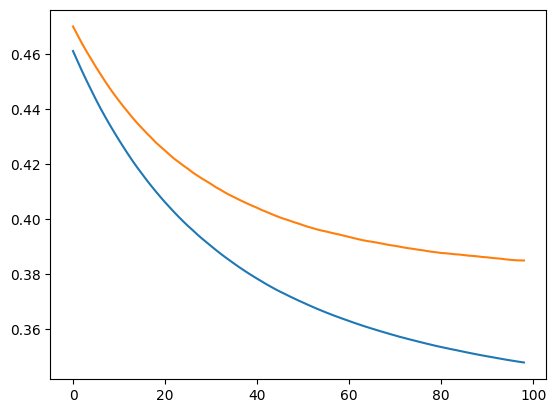

In [20]:
plt.plot(boosting.loss)
plt.plot(boosting.loss_eval)

## Q2 (4 pt). Use your trained Boosting classifier.
(a) Choose the threshold form (0, 1) to get recall $\approx 0.5$ on the validation set.

`recall_score((y_val+1)//2, boosting.predict_proba(X_val_transformed)>threshhold)`

(b) Plot Confusion Matrix for the Test based on this threshhold and calculate recall on Test.

(c) Plot ROC curve

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, RocCurveDisplay

In [43]:
#find best threshold
needed_recall = 0.5
best = 1.0
best_threshold = 1.0
for threshold in range(0, 1001):
  threshold *= 0.001
  resulting_recall = abs(recall_score((y_val+1)//2, boosting.predict_proba(X_val_transformed)>threshold) - needed_recall)
  if (resulting_recall < best):
    best = resulting_recall
    best_threshold = threshold

print(f"Best threshold : {best_threshold}")

Best threshold : 0.256


In [44]:
recall_score((y_val+1)//2, boosting.predict_proba(X_val_transformed)>best_threshold)

0.4973284011508426

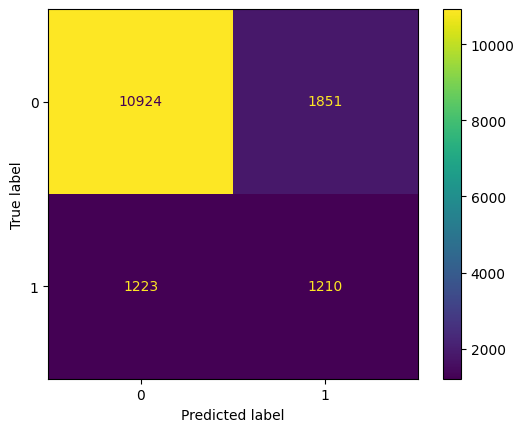

In [45]:
ConfusionMatrixDisplay.from_predictions((y_val+1)//2, boosting.predict_proba(X_val_transformed)>best_threshold)

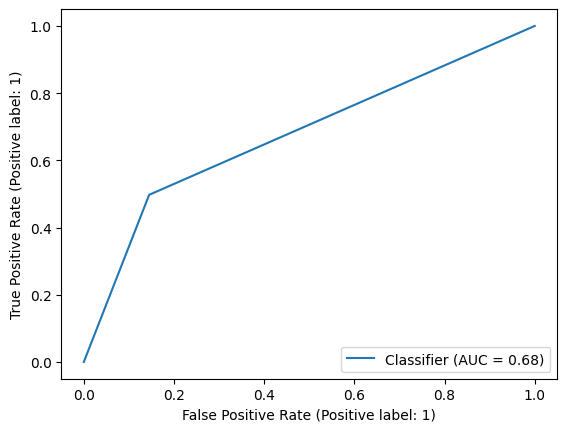

In [46]:
RocCurveDisplay.from_predictions((y_val+1)//2, boosting.predict_proba(X_val_transformed)>best_threshold)

## Q3 (4 pt). Train LightGBM Classifier on your data.
(a) Choose the threshold form (0, 1) to get recall $\approx 0.5$ on the validation set.

`recall_score((y_val+1)//2, gb.predict_proba(X_val_transformed)[:,1]>threshhold)`

(b) Plot Confusion Matrix for the Test based on this threshhold and calculate recall on Test.

(c) Plot ROC curve

`RocCurveDisplay.from_predictions(y_test, gb.predict_proba(X_test_transformed)[:,1])`

(d) Compare with the result of your model from Q2.

In [11]:
import lightgbm as lgb

In [49]:
gb = lgb.LGBMClassifier()
gb.fit(X_train_transformed, y_train)

[LightGBM] [Info] Number of positive: 6920, number of negative: 38702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 45622, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151681 -> initscore=-1.721476
[LightGBM] [Info] Start training from score -1.721476


LGBMClassifier()

In [50]:
#find best threshold
needed_recall = 0.5
best = 1.0
best_threshold = 1.0
for threshold in range(0, 1001):
  threshold *= 0.001
  resulting_recall = abs(recall_score((y_val+1)//2, gb.predict_proba(X_val_transformed)[:,1]>threshold) - needed_recall)
  if (resulting_recall < best):
    best = resulting_recall
    best_threshold = threshold

print(f"Best threshold : {best_threshold}")

Best threshold : 0.275


In [51]:
recall_score((y_val+1)//2, gb.predict_proba(X_val_transformed)[:,1]>best_threshold)

0.4989724619810933

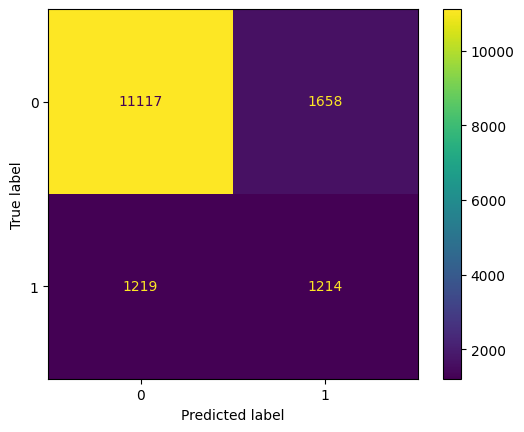

In [52]:
ConfusionMatrixDisplay.from_predictions((y_val+1)//2, gb.predict_proba(X_val_transformed)[:,1]>best_threshold)

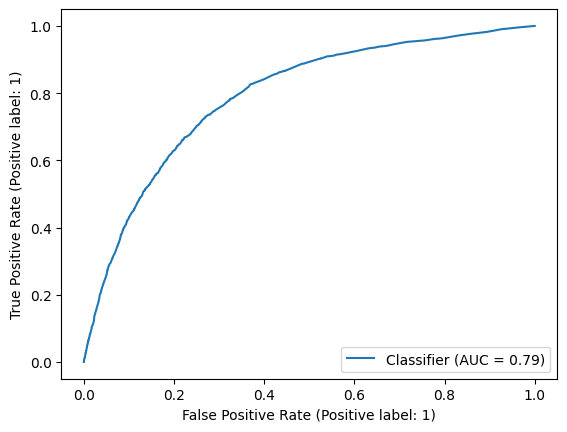

In [53]:
RocCurveDisplay.from_predictions(y_test, gb.predict_proba(X_test_transformed)[:,1])

Are you satisfied with the result?

***LightGBM seems to do a better job***